Authors: Sruthi Suresh and Vidhi Mehta

For our first Kaggle kernel, we have decided to tackle the Titanic - Machine Learning from Disaster project. Our project will primarily focus on feature selection, Exploratory Data Analysis, and using logistic regression to solve this binary classification problem.
In order to label a given passenger with their survival status, we will use a binary logistic regression model. 

1.   **Loading Data and Libraries**
2.   **Data Cleaning**
3.   **Exploratory Data Analysis**
4.   **Binary Logistic Regression Model and Feature Selection**

# Loading Data and Libraries

The data provided for the competition consists of the training data (which is labeled with survival status) and the test data (which the developed model needs to label).
Additionally, the necessary data processing packages and machine learning libraries need to be loaded as well.

In [ ]:
# Loading Data Processing Packages
import numpy as np # linear algebra
import pandas as pd # data frame manipulation
from numpy import nan
from numpy import isnan
from pandas import read_csv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MultiLabelBinarizer
import random
from scipy.stats import chi2_contingency

# importing dython for visualization of categorical data
!pip install dython
from dython import nominal
from dython.nominal import associations

# Loading Data Visualization Libraries
!pip install chart_studio
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
!pip install dexplot


# Loading Packages for Binary Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [ ]:
train = pd.read_csv("/content/train.csv") #loading training data
testsubmission = pd.read_csv("/content/test.csv") #loading test data
train.info() # Gleaning basic information needed for data cleaning, note that dtypes may be changed to float64 for more accurate computations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
testsubmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
pd.options.display.max_columns = None
display(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Clearly, we need to address the missing values of the Age, Cabin, and Embarked columns during our data cleaning.
Additionally, one row in the testing dataset is missing the fare value.

# Data Cleaning


## Embarked and Fare

First, we will consider the Embarked location - as there are only two missing values, we can simply assign the most common class (an imputation method).

In [ ]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].value_counts().index[0])
# All NA accounted for!

Let us quickly address the Fare value as well with the same imputation method.

In [ ]:
testsubmission['Fare'] = testsubmission['Fare'].fillna(testsubmission['Fare'].value_counts().index[0])
# All NA accounted for!

## Age and Correlation Heatmap

Next, the Age class needs to account for its missing values as well. 
We first check to see if there is a systematic difference between passengers with missing values for ages and the available data.
To do this, we will create a correlation heatmap using the associations function in the dython library.

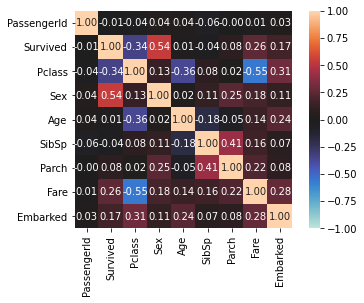

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7feeb7285908>,
 'corr':              PassengerId  Survived    Pclass       Sex       Age     SibSp  \
 PassengerId     1.000000 -0.005007 -0.035144  0.042939  0.038125 -0.057527   
 Survived       -0.005007  1.000000 -0.338481  0.543351  0.010539 -0.035322   
 Pclass         -0.035144 -0.338481  1.000000  0.131900 -0.361353  0.083081   
 Sex             0.042939  0.543351  0.131900  1.000000  0.024978  0.114631   
 Age             0.038125  0.010539 -0.361353  0.024978  1.000000 -0.184664   
 SibSp          -0.057527 -0.035322  0.083081  0.114631 -0.184664  1.000000   
 Parch          -0.001652  0.081629  0.018443  0.245489 -0.048786  0.414838   
 Fare            0.012658  0.257307 -0.549500  0.182333  0.135516  0.159651   
 Embarked        0.034183  0.170707  0.306858  0.110742  0.240058  0.069347   
 
                 Parch      Fare  Embarked  
 PassengerId -0.001652  0.012658  0.034183  
 Survived     0.081629  0.257307  0.170707  

In [ ]:
heatmap = pd.DataFrame(train)
# Remove name, ticket and cabin columns as they are independent from this value and will not be useful for the heatmap.
heatmap = heatmap.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
nominal.associations(heatmap, nominal_columns=['Sex','Embarked'])

Clearly, we can see some features that correlate with the age variable. 
These include:
*   PClass: Correlation of -0.36,     computed using Pearson's R.
*   Embarked Location: Correlation of 0.24, computed using Correlation Ratio.
*   SibSp: Correlation of -0.18, computed using Pearson's R.

We may use the median values of these grouped by columns to impute reasonable age values.

In [ ]:
print(train.groupby(['Pclass','Embarked','SibSp'])['Age'].median())
train['Age'] = train.groupby(['Pclass','Embarked','SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))
testsubmission['Age'] = testsubmission.groupby(['Pclass','Embarked','SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))

Pclass  Embarked  SibSp
1       C         0        36.00
                  1        40.00
                  2        19.50
        Q         1        33.00
                  2        44.00
        S         0        38.50
                  1        36.00
                  2        51.50
                  3        23.00
2       C         0        23.00
                  1        27.50
        Q         0        43.50
        S         0        30.00
                  1        29.00
                  2        23.50
                  3        30.00
3       C         0        24.50
                  1        15.00
                  2         0.75
        Q         0        23.50
                  1        36.00
                  2          NaN
                  4         5.50
        S         0        26.00
                  1        26.00
                  2        24.00
                  3         6.00
                  4         6.50
                  5        11.00
                  8

In [ ]:
# Less than 10 missing values, we will fill with random ages in the IQR of the age (22 and 36/37), found using df.describe().
train['Age'] = train['Age'].fillna(random.random() * 14 + 22)
testsubmission['Age'] = testsubmission['Age'].fillna(random.random() * 15 + 22)
# All NA accounted for!

## Cabin Column

Next we will extract cabin information based on the "Deck" of the cabin. Unknown cabins will be assigned the value of "U" referencing https://github.com/Erlemar/Erlemar.github.io/blob/master/Notebooks/Titanic.ipynb.

In [ ]:
train.Cabin.fillna('Unknown',inplace=True)
testsubmission.Cabin.fillna('Unknown',inplace=True)
train['Cabin'] = train['Cabin'].map(lambda x: x[0]) # mapping to first character
testsubmission['Cabin'] = testsubmission['Cabin'].map(lambda x: x[0])


## Creating Age Groups

Creating Age Groups so that our EDA may also consider these data ranges rather than simply comparing the continuous age data with the binary survival status.

In [ ]:
train['Age Groups'] = pd.cut(train['Age'], range(0, 81, 10), right=True, labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70-80'])
testsubmission['Age Groups'] = pd.cut(testsubmission['Age'], range(0, 81, 10), right=True, labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '70-80'])

# Exploratory Data Analysis

## Age

Let's first look at age and see if there's a correlation with survival rate.
Before assigning 'age groups', let's first check the point biserial correlation https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html.**update** 

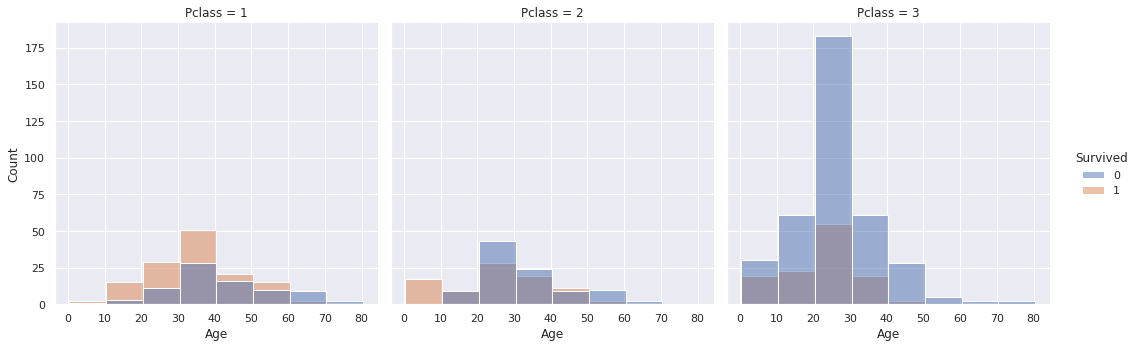

In [ ]:
sns.set_theme(color_codes=True)
sns.displot(train, x='Age', col = 'Pclass', hue = 'Survived', binwidth = 10)

In certain age groups, there were distinct patterns of who survived vs. who didn't when looked at in the context of Pclasses.
In Pclass 1, more people survived in age groups other than the 60-80 group.
In Pclass 2, more people died in the groups that were not in 0-10 (or 40-50 by a small margin).
In Pclass 3, more people died in all the age groups, with a significant margin in the 20-30 age group.

In [ ]:
sp.stats.pointbiserialr(train['Age'], train['Survived']) # relationship between a binary variable, survived, and a continuous variable, age.

PointbiserialrResult(correlation=-0.04553709772891183, pvalue=0.1744441526444173)

Interestingly, there doesn't seem to be a strong correlation - let us try to visualize these two variables.

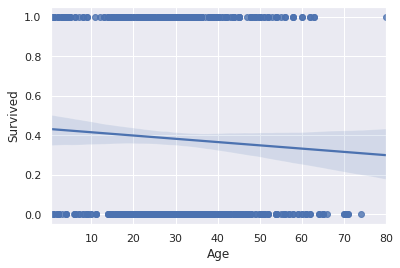

In [ ]:
sns.regplot(x='Age', y='Survived', data=train, x_jitter=.05);

There's an evident correlation with the data when plotted in this manner.

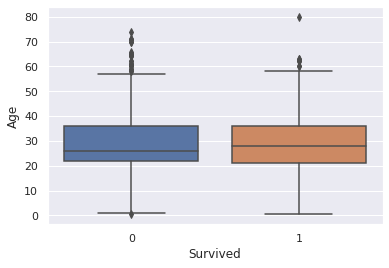

In [ ]:
sns.boxplot(x='Survived', y='Age', data=train);

This is consistent with our understanding of the data.
https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Point-Biserial_and_Biserial_Correlations.pdf

In [ ]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum() 
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
confusion_matrix = pd.crosstab(train['Age Groups'], train['Survived'])
cramers_corrected_stat(confusion_matrix)

0.11678423180893414

With Age Groups, we find that the correlation is much stronger (http://www.acastat.com/statbook/chisqassoc.htm#:~:text=between%20the%20variables.-,It%20is%20interpreted%20as%20a%20measure%20of%20the%20relative%20(strength,substantive%20relationship%20between%20two%20variables.), with a corrected Cramer's V of .124 (above "the minimum threshold for suggesting there is a substantive relationship between two variables").

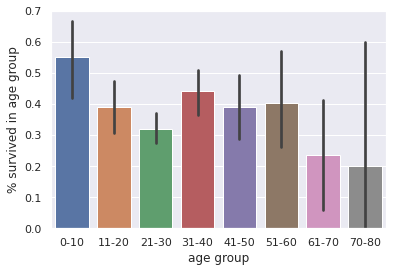

In [ ]:
ax = sns.barplot(x="Age Groups", y="Survived", data=train)
ax.set(xlabel='age group', ylabel= '% survived in age group')
plt.show()

The age groups have a clear distinction in survival rate, with there being a univariate distribution - the highest survival rate is in the age group of 0-10, although there is no clear trend in across age groups.

## Sex

We predict that there will be a strong correlation between sex and survival rate, further proved by the graph below.
Our Cramer's V test also shows a substantive correlation.

0.5401999468101071

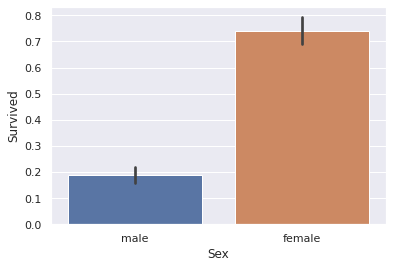

In [ ]:
sns.barplot(x="Sex", y="Survived", data=train)
confusion_matrix = pd.crosstab(train['Sex'], train['Survived'])
cramers_corrected_stat(confusion_matrix)

Now let's compare the groups split by survival status and specifically focus on the sex of the passenger!

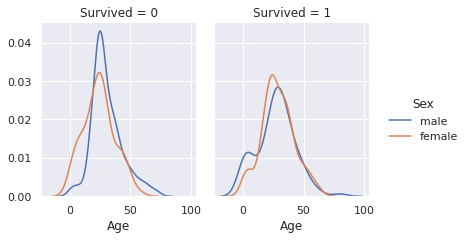

In [ ]:
survived = train.loc[(train['Survived'] == 1)]
dead = train.loc[(train['Survived'] == 0)]
g = sns.FacetGrid(train, col='Survived', hue='Sex', margin_titles=True, height=3.5, aspect=.8)
g.map(sns.distplot,'Age', hist = False, kde_kws=dict(alpha=0.6), bins = 8)
g.add_legend()  


Pretty interesting distribution - they are similar although the average age of a surviving male is slightly higher and the distribution is more strongly unimodal.The modal age of a surviving female is roughly the same as a deceased female - strongly contrasting the differing survival rate in men.

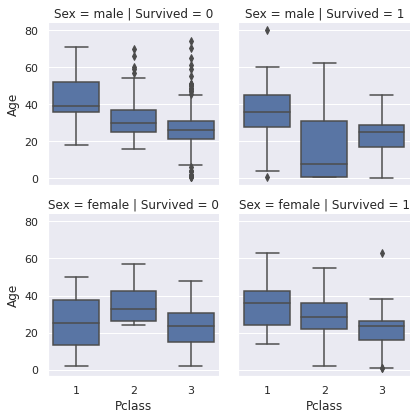

In [ ]:
def fixed_boxplot(*args, label=None, **kwargs):
    sns.boxplot(*args, **kwargs, labels=[label]) # https://github.com/mwaskom/seaborn/issues/915
g = sns.FacetGrid(train, col='Survived', row='Sex')
g.map(fixed_boxplot, 'Pclass', 'Age')

There are interesting observations to made from this chart. Clearly, surviving males were on average in Pclass 2 and of a younger age, with Pclass 3 having the most difficult trends to track (see the high number of outliers).
Deceased women in Pclass 1 were younger than their surviving counterparts, while those in Pclass 2 were slightly older and Pclass 3 with a roughly similar age.

## Cabin and Embarked


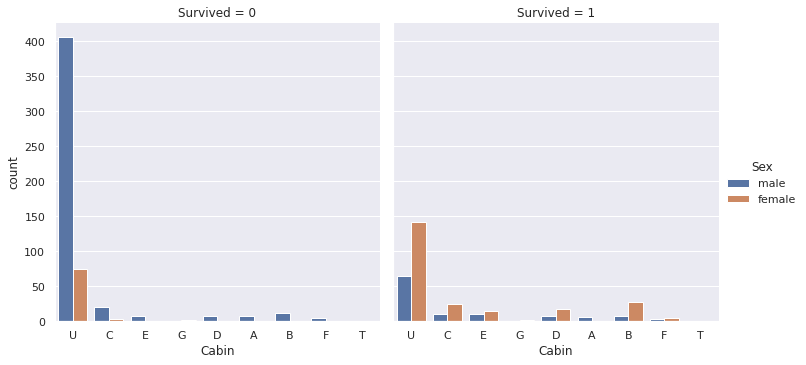

In [ ]:
sns.catplot(x="Cabin", data=train, hue = "Sex", col = "Survived", kind = "count")

Here we can see the distribution of people in cabins and whether they lived or died. Interestingly, it seems that the from those whose cabins were known, the women who passed away were in the C, E, and G cabins (although of course the women who passed away were mainly in the "U" category), while those who survived were in the C, E and B cabins. The most men in the B and C cabins survived.
The people whose cabins were unknown most likely passed away in the disaster. The surviving people in the unknown cabin were more likely female whereas the opposite was true for the deceased passengers.

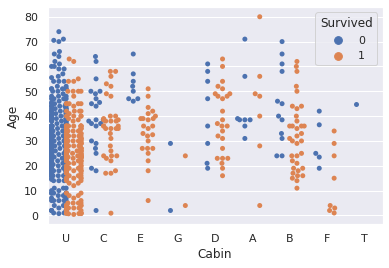

In [ ]:
sns.swarmplot(x='Cabin', y='Age', hue='Survived', data=train, dodge=True)

Now looking at the age distributions in the cabin, we can see that in cabins C, D and G,  the age distribution of the surviving and deceased groups are roughly similar, whereas there are significant differences in E (older passengers died), A (the range of surviving passengers was much more variable), B with a younger group of surviving passengers and T with the only passenger dying.
Cabin E has a very interesting distribution with respect to age.

In [ ]:
Qs = train.loc[(train['Embarked'] == 'Q') & (train['Sex'] == "male") ]
Qs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 5 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  41 non-null     int64   
 1   Survived     41 non-null     int64   
 2   Pclass       41 non-null     int64   
 3   Name         41 non-null     object  
 4   Sex          41 non-null     object  
 5   Age          41 non-null     float64 
 6   SibSp        41 non-null     int64   
 7   Parch        41 non-null     int64   
 8   Ticket       41 non-null     object  
 9   Fare         41 non-null     float64 
 10  Cabin        41 non-null     object  
 11  Embarked     41 non-null     object  
 12  Age Groups   41 non-null     category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 4.6+ KB


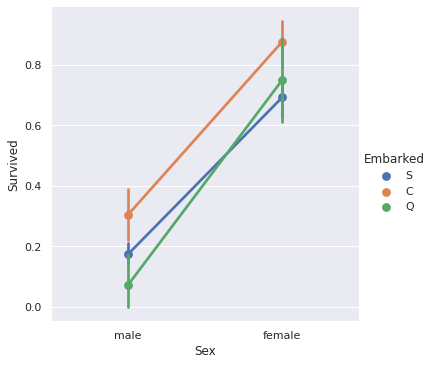

In [ ]:
sns.catplot(x="Sex", y="Survived", hue="Embarked", kind="point", data=train)

The biggest difference in survival rates between sexes with respect to embarked location was in the Q location, whereas the C, S locations have the same slope/percent difference in survival rate - an interesting find!
Interestingly, this means that all 41 men died and 36 women survived from the 77 passengers!

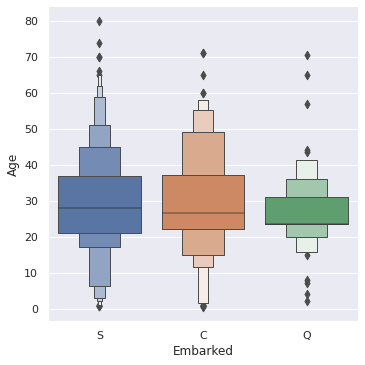

In [ ]:
sns.catplot(x="Embarked", y="Age", kind="boxen", data = train)

When looking at the Boxen plots (which showcase detailed distributions - with quartiles specifically), we can see that Q has the least variation,
S has a more variable distribution and C has a lower deviation (with roughly the same median age).


## P-Class

Now we will take a look at how the P-Class variable relates to the other variables in our training dataset. As we can see below, the 3rd P-Class not only has a lot more deaths compared to the other P-Classes, but we can also see that the average age for this class is lower at around 25 years. 

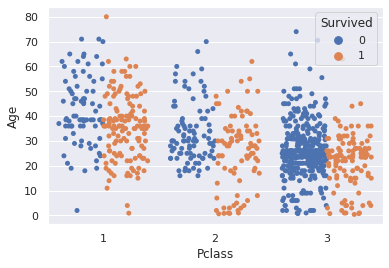

In [ ]:
sns.stripplot(train['Pclass'], train['Age'], hue= train['Survived'], jitter=0.40, dodge=True)

The graph provided below helps us compare the fair price with the P class. We can see that the fare cost for the P-Classes is lowest for 3rd P-Class and highest for the 1st P-Class. We can also see how the fare cost average of the people who died is lower than that of the fare cost of people who survived. 

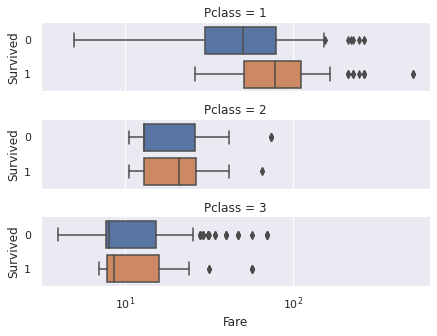

In [ ]:
g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=4,
                data=train.query("Fare > 0"))
g.set(xscale="log")

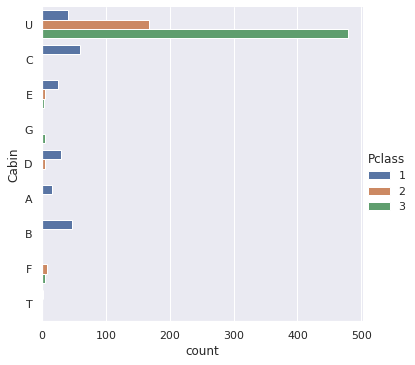

In [ ]:
sns.catplot(y="Cabin", hue="Pclass", kind="count",data=train)

For the barplot, we see that most people in cabins C, E, D, A and B (and the one person in T) were in the first Pclass, whereas the F cabin had the most 2, 3 classes of the known ones.
The people in Pclass 3 and 2 were most likely in the "Unknown" category.

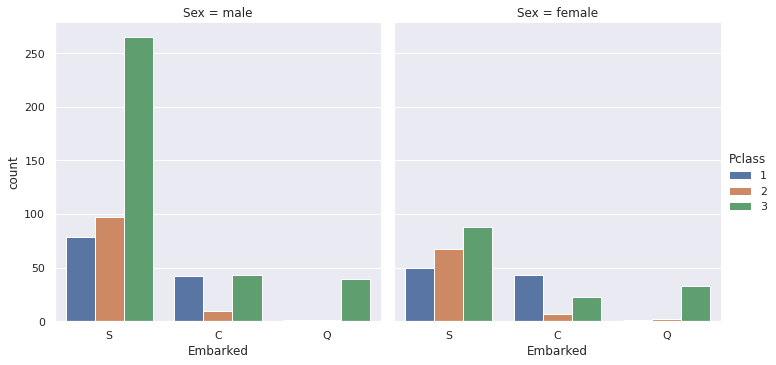

In [ ]:
sns.catplot(x="Embarked", data=train, hue = "Pclass", col= "Sex", kind = "count")

As we can see from the plot above, the people who departed from the S location tend to belong to the 3rd class. Whereas people that embarked from the C location tend to be from the 1st class.

# Preparing Data (One Hot Encoding)
We now are ready to start with the model creation. First, let's convert the dataset into one which we can use for the Logistic Regression model (includes one hot encoding).

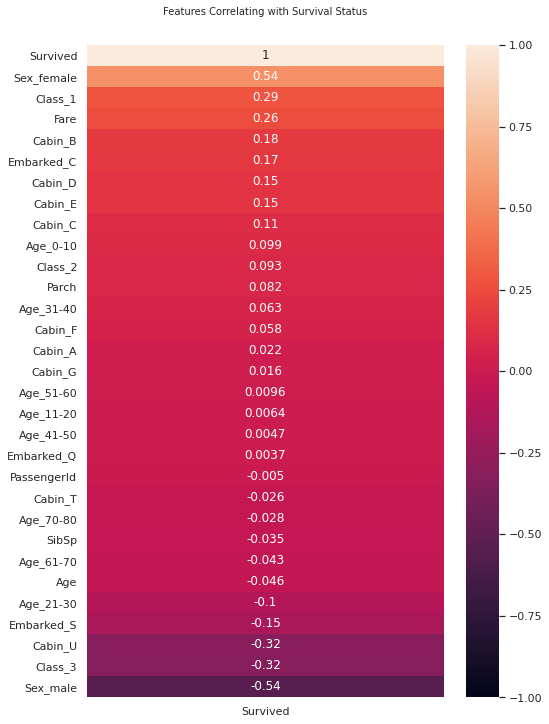

In [ ]:
prep = train
prep = prep.drop(['Name', 'Ticket'], axis = 1)
prep = pd.concat([prep,pd.get_dummies(prep['Sex'], prefix='Sex')],axis=1)
prep = pd.concat([prep,pd.get_dummies(prep['Pclass'], prefix='Class')],axis=1)
prep = pd.concat([prep,pd.get_dummies(prep['Cabin'], prefix='Cabin')],axis=1)
prep = pd.concat([prep,pd.get_dummies(prep['Embarked'], prefix='Embarked')],axis=1)
prep = pd.concat([prep,pd.get_dummies(prep['Age Groups'], prefix='Age')],axis=1)

del prep['Sex']
del prep['Pclass']
del prep['Cabin']
del prep['Embarked']
del prep['Age Groups']
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(prep.corr()[['Survived']].sort_values(by='Survived', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Survival Status', fontdict={'fontsize':10}, pad=30);


This heatmap helps us visualize the correlation between the various features with survival. As we initially predicted, there is a strong positive correlation between being a female and the survival rate and a strong negative correlation between being a male and the survival rate. The 1st class members have the next highest probability of surviving. This makes sense because they were given priority over the 3rd class passengers. Our heatmap provides insight into the "coefficient" feature selection method used as the standard.

# Logistic Regression and Feature Selection
Now we will import the model and apply it to our training and test datasets.
First, we will split the training dataset into an 80% training and 20% testing dataset and prepare the data. We will first do the standard model.

In [ ]:
training, testing = train_test_split(prep, test_size=0.2)
logregression = LogisticRegression()
X_train=training.drop(['Survived'], axis = 1) # splitting training into x and y data
Y_train=training['Survived']
logregression.fit(X_train, Y_train)
logregression.score(X_train, Y_train)

0.8216292134831461

Even without doing feature ranking, we averaged at an accuracy of about 81% on the split training data. Let's see how the testing dataset works.

In [ ]:
logregression.fit(X_train, Y_train)
X_test = testing.drop(['Survived'], axis = 1)
Y_test= testing['Survived']
testingacc = logregression.predict(X_test)
logregression.score(X_test, Y_test)

0.7988826815642458

We see that it has an accuracy score of about 74-75% on the testing data. Before we fit this model to the actual prediction dataset, let us tweak the features.
We are going to use Chi2 and RFE feature selection methods.

In [ ]:
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X_train, Y_train)
cols = test.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]
print(features_df_new)

        Fare  Sex_female  Sex_male
449  30.5000           0         1
298  30.5000           0         1
749   7.7500           0         1
465   7.0500           0         1
0     7.2500           0         1
..       ...         ...       ...
579   7.9250           0         1
489  15.9000           0         1
728  26.0000           0         1
262  79.6500           0         1
97   63.3583           0         1

[712 rows x 3 columns]


In [ ]:
chi = prep[['Fare', 'Sex_female', 'Class_2','Survived']]
training, testing = train_test_split(chi, test_size=0.2)
logregression = LogisticRegression()
X_train=training.drop(['Survived'], axis = 1) # splitting training into x and y data
Y_train=training['Survived']
logregression.fit(X_train, Y_train)
print(logregression.score(X_train, Y_train))
logregression.fit(X_train, Y_train)
X_test = testing.drop(['Survived'], axis = 1)
Y_test= testing['Survived']
testingacc = logregression.predict(X_test)
print(logregression.score(X_test, Y_test))

0.7935393258426966
0.7374301675977654


We see that the Chi-square feature selection with the top 3 features has a much higher accuracy variation from 71% to 82%.
Let's try the RFE method!

In [ ]:
training, testing = train_test_split(prep, test_size=0.2)
logregression = LogisticRegression()
X_train=training.drop(['Survived'], axis = 1) # splitting training into x and y data
Y_train=training['Survived']
rfe = RFE(logregression, 6)
fit = rfe.fit(X_train, Y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
print(np.where(fit.ranking_ == 1))


Num Features: 6
Selected Features: [False False False False False  True  True False False  True False False
 False False False False  True False  True False False False  True False
 False False False False False False]
Feature Ranking: [25 23  9 17 24  1  1  8 15  1 10 16 22  2  5  7  1 12  1 18 19  4  1 21
 14 20 13  6 11  3]
(array([ 5,  6,  9, 16, 18, 22]),)


It selected top 6 features of Fare, Sex_female, Class_2, Cabin_T, Age 41-50 and Embarked_S. Let us recreate the model only using these features and check the accuracy. We will discard column Cabin_T as it only had one passenger that is not represented in the final testing set.

In [ ]:
rfe = prep[['Fare', 'Sex_female', 'Class_2', 'Age_41-50', 'Embarked_S', 'Survived']]
training, testing = train_test_split(rfe, test_size=0.2)
logregression = LogisticRegression()
X_train=training.drop(['Survived'], axis = 1) # splitting training into x and y data
Y_train=training['Survived']
logregression.fit(X_train, Y_train)
print(logregression.score(X_train, Y_train))
logregression.fit(X_train, Y_train)
X_test = testing.drop(['Survived'], axis = 1)
Y_test= testing['Survived']
testingacc = logregression.predict(X_test)
print(logregression.score(X_test, Y_test))

0.7794943820224719
0.7932960893854749


The accuracy for the test dataset increased to a range of about 75%-81%. Because of the better accuracy, we will use the RFE-selection method in our logistic regression model. We will now create our submission.

# Preparing Test Dataset and Applying Model

Now let's apply the same preprocessing steps and then apply our model!

In [ ]:
testsubmission = testsubmission.drop(['Name', 'Ticket'], axis = 1)
testsubmission = pd.concat([testsubmission,pd.get_dummies(testsubmission['Sex'], prefix='Sex')],axis=1)
testsubmission = pd.concat([testsubmission,pd.get_dummies(testsubmission['Pclass'], prefix='Class')],axis=1)
testsubmission = pd.concat([testsubmission,pd.get_dummies(testsubmission['Cabin'], prefix='Cabin')],axis=1)
testsubmission = pd.concat([testsubmission,pd.get_dummies(testsubmission['Embarked'], prefix='Embarked')],axis=1)
testsubmission = pd.concat([testsubmission,pd.get_dummies(testsubmission['Age Groups'], prefix='Age')],axis=1)
del testsubmission['Sex']
del testsubmission['Pclass']
del testsubmission['Cabin']
del testsubmission['Embarked']
del testsubmission['Age Groups']


In [ ]:
testsubmission=testsubmission[['Fare', 'Sex_female', 'Class_2', 'Age_41-50', 'Embarked_S']]
prediction_submission = logregression.predict(testsubmission)
testindex = pd.read_csv("/content/test.csv") #loading test data
finalsubmission = pd.DataFrame({
      "PassengerId": testindex["PassengerId"],
        "Survived": prediction_submission
   })
finalsubmission.to_csv('finalsubmission.csv', index=False)